# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

C:\Users\laptop\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Generate Sample Ticket Data

In [2]:
np.random.seed(42)
n = 300
created_dates = pd.to_datetime("2024-01-01") + pd.to_timedelta(
    np.random.randint(0, 60, n), unit="D"
)
resolution_days = np.random.choice(
    [np.nan, 1, 2, 3, 5, 7, 10, 15],
    size=n,
    p=[0.25, 0.15, 0.15, 0.15, 0.1, 0.1, 0.05, 0.05]
)
closed_dates = [
    c + pd.Timedelta(days=int(r)) if not np.isnan(r) else pd.NaT
    for c, r in zip(created_dates, resolution_days)
]
tiers = np.random.choice(["Tier 1", "Tier 2", "Tier 3"], size=n, p=[0.5, 0.3, 0.2])
df = pd.DataFrame({
    "ticket_id": range(1, n + 1),
    "created_at": created_dates,
    "closed_at": closed_dates,
    "support_tier": tiers
})
df.head()

,ticket_id,created_at,closed_at,support_tier
0,1,2024-02-08,2024-02-15,Tier 1
1,2,2024-02-21,2024-02-22,Tier 1
2,3,2024-01-29,NaT,Tier 3
3,4,2024-01-15,NaT,Tier 1
4,5,2024-02-12,2024-02-15,Tier 3


# Saving the CSV file

In [3]:
df.to_csv("ticket_history.csv", index=False)

# Data Understanding & Cleaning

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ticket_id     300 non-null    int64         
 1   created_at    300 non-null    datetime64[ns]
 2   closed_at     224 non-null    datetime64[ns]
 3   support_tier  300 non-null    object        
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 9.5+ KB


# Create Event & Duration Columns


In [5]:
df["event_resolved"] = df["closed_at"].notna().astype(int)

# Calculate Resolution Time

In [6]:
today = pd.Timestamp.today()
df["resolution_time"] = (
    df["closed_at"].fillna(today) - df["created_at"]
).dt.days

# Survival Analysis

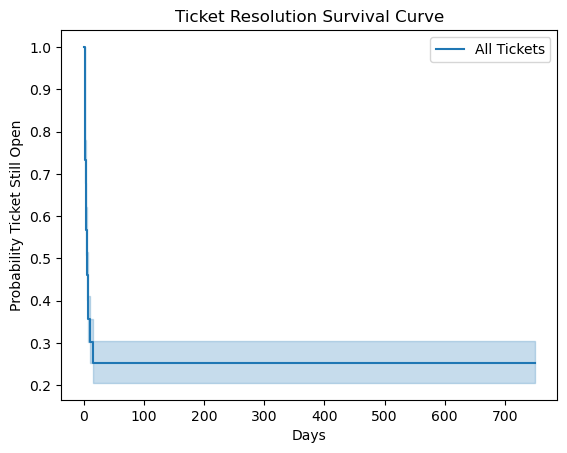

In [7]:
kmf = KaplanMeierFitter()
kmf.fit(
    durations=df["resolution_time"],
    event_observed=df["event_resolved"],
    label="All Tickets"
)
kmf.plot_survival_function()
plt.title("Ticket Resolution Survival Curve")
plt.xlabel("Days")
plt.ylabel("Probability Ticket Still Open")
plt.show()

# Compare Support Tiers

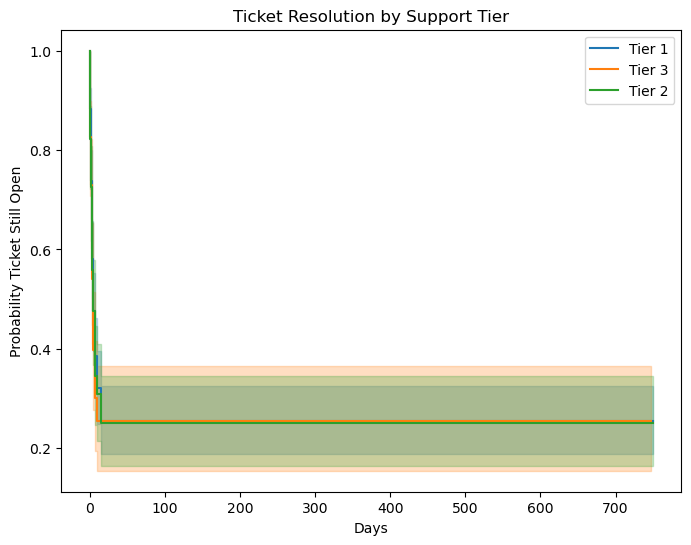

In [8]:
plt.figure(figsize=(8,6))
for tier in df["support_tier"].unique():
    tier_data = df[df["support_tier"] == tier]
    kmf.fit(
        tier_data["resolution_time"],
        tier_data["event_resolved"],
        label=tier
    )
    kmf.plot_survival_function()
plt.title("Ticket Resolution by Support Tier")
plt.xlabel("Days")
plt.ylabel("Probability Ticket Still Open")
plt.legend()
plt.show()

# Median Resolution Time

In [9]:
kmf = KaplanMeierFitter()
for tier in df["support_tier"].unique():
    tier_data = df[df["support_tier"] == tier]
    kmf.fit(
        tier_data["resolution_time"],
        tier_data["event_resolved"],
        label=tier
    )
    print(f"{tier} - Median Resolution Time:", kmf.median_survival_time_)

Tier 1 - Median Resolution Time: 5.0
Tier 3 - Median Resolution Time: 5.0
Tier 2 - Median Resolution Time: 5.0


# Statistical Comparison

In [10]:
from lifelines.statistics import logrank_test
tier1 = df[df["support_tier"] == "Tier 1"]
tier3 = df[df["support_tier"] == "Tier 3"]
result = logrank_test(
    tier1["resolution_time"],
    tier3["resolution_time"],
    event_observed_A=tier1["event_resolved"],
    event_observed_B=tier3["event_resolved"]
)
result.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.28 0.60      0.74

# SLA Breach Analysis

In [11]:
sla_days = 5
df["sla_breached"] = df["resolution_time"] > sla_days
df.groupby("support_tier")["sla_breached"].mean() * 100

support_tier
Tier 1    47.712418
Tier 2    47.619048
Tier 3    39.682540
Name: sla_breached, dtype: float64

# Final Summary Table

In [12]:
summary = df.groupby("support_tier").agg(
    total_tickets=("ticket_id", "count"),
    resolved_pct=("event_resolved", "mean"),
    avg_resolution_days=("resolution_time", "mean"),
    sla_breach_pct=("sla_breached", "mean")
)
summary["resolved_pct"] *= 100
summary["sla_breach_pct"] *= 100
summary

,total_tickets,resolved_pct,avg_resolution_days,sla_breach_pct
support_tier,,,,
Tier 1,153,74.509804,187.261438,47.712418
Tier 2,84,75.000000,183.714286,47.619048
Tier 3,63,74.603175,186.031746,39.682540
